# Music Genre Classification

## Recurrent Neural Network Implementation

Fabrizio Niro - Jacopo Signò

GTZAN Dataset - Music Genre Classification 

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

In [9]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torchinfo import summary
import pickle
import numpy as np
import torchvision
from d2l import torch as d2l
from torch.utils import data

In [118]:
with open('Processed_data/RNN/data_train', 'rb') as f:
    data_train = pickle.load(f)

with open('Processed_data/RNN/data_test', 'rb') as f:
    data_test = pickle.load(f)

In [119]:
print(len(data_train), len(data_train[0]))

8000 2


In [120]:
print(len(data_test), len(data_test[0]))

2000 2


In [121]:
batch_size = 64

train_iter = data.DataLoader(data_train, batch_size, shuffle=True,
                             num_workers = 2)

In [122]:
train_iter

In [123]:
next(iter(train_iter))

[tensor([[[-2.7049e+00, -2.5698e+00, -2.7166e+00,  ..., -3.7682e+00,
           -3.7621e+00, -3.6691e+00],
          [ 3.1839e+00,  3.1886e+00,  3.0071e+00,  ...,  2.1788e+00,
            2.2093e+00,  2.3995e+00],
          [-2.9596e-01, -4.6007e-01, -4.7902e-01,  ...,  5.5723e-01,
            5.1407e-01,  5.0341e-01],
          ...,
          [ 6.2553e-02, -7.4251e-03, -1.0550e-01,  ...,  2.7332e-01,
            2.4427e-01,  1.8913e-01],
          [ 1.3447e-01,  2.5345e-01,  1.5450e-01,  ...,  1.2270e-01,
            1.1539e-01,  1.2582e-01],
          [-5.8285e-01, -3.7773e-01, -1.9974e-01,  ..., -1.7948e-02,
           -2.0756e-02,  1.1948e-02]],
 
         [[-3.3311e+00, -3.4566e+00, -3.7340e+00,  ..., -3.7211e+00,
           -3.7210e+00, -3.7155e+00],
          [ 2.8234e+00,  2.7198e+00,  2.3274e+00,  ...,  2.2934e+00,
            2.2831e+00,  2.3072e+00],
          [ 2.2894e-01,  1.9202e-01,  2.1103e-01,  ...,  8.1768e-01,
            8.3387e-01,  8.2827e-01],
          ...,
    

In [124]:
test_iter = data.DataLoader(data_test, batch_size, shuffle=False,
                             num_workers = 2)

In [125]:
test_iter

In [126]:
next(iter(test_iter))[0].shape

torch.Size([64, 20, 129])

In [176]:
next(iter(test_iter))[0][0].shape

torch.Size([20, 129])

In [128]:
input_num = 20 * 129 
input_num

2580

In [158]:
nn.Flatten(next(iter(test_iter))[0][0])

Flatten(
  start_dim=tensor([[-0.5659,  1.9504, -0.2295,  ..., -2.7402, -1.8414, -2.2186],
          [ 3.0932,  2.3339,  1.8888,  ...,  1.0121, -0.1160, -0.3198],
          [ 2.3576,  2.1849,  2.8129,  ...,  1.7457,  1.3257,  1.0361],
          ...,
          [-1.1279, -1.0410, -1.1679,  ..., -0.5631, -1.1284, -1.7749],
          [-0.7204, -0.9404, -1.1938,  ...,  0.0230,  0.6374,  0.2416],
          [-0.8409, -0.9972, -0.8509,  ..., -0.5654,  0.0075,  0.6030]]), end_dim=-1
)

In [177]:
# PyTorch does not implicitly reshape the inputs. Thus we define the "flatten"
# layer to reshape the inputs before the linear layer in our network
net = nn.Sequential(nn.Flatten(), nn.Linear(input_num, 20)) # if softmax not specified pytorch does the prediction bec of argmax(yhat) = argmax(oj)

def init_weights(m): # argument m shall be a layer
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights); # apply() will call init_weights() providing it with each layer of net as actual argument m

In [169]:
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

In [170]:
def train_epoch(net, train_iter, loss, updater):
    """The training loop"""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, nb. of examples
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        updater.zero_grad()
        l.backward()
        updater.step()
        metric.add(float(l) * len(y), d2l.accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [171]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    """Train a model"""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        # ! WARNING !: d2l.evaluate_accuracy() no longer defined. Use d2l.evaluate_accuracy_gpu() instead
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    return train_loss, train_acc

Loss:  3.116432970046997
Accuracy:  0.018875


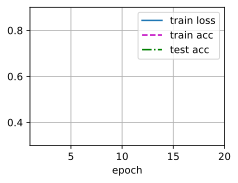

In [174]:
num_epochs = 20
train_loss, train_acc = train(net, train_iter, test_iter, loss, num_epochs, trainer)
print("Loss: ", train_loss)
print("Accuracy: ", train_acc)